# IERG 6130 Assignment 4: Reinforcement Learning Pipeline in Practice

*2019-2020 2nd term, IERG 6130: Reinforcement Learning and Beyond. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao.*



*You do not need to submit this file.*

------

Welcome to assignment 4 of our RL course! 

Please refer to the `README.md` file for logistics of this assignment. We discuss the files you need to finish, deliverable and credits policy of this assignment.


## Section 1: Get familiar with the environment

The environment we used in this assignment is developed by *Billy Ho* (1155079385 AT link.cuhk.edu.hk) and *Joe Lam* (joelam1227 AT gmail.com), undergraduate students at CUHK, as their Final Year Project (FYP) with Prof. Zhou. The system is still being developed, and we only take part of the functionalities and aggregate them into this assignment. We appreciate Billy and Joe for sharing this excellent platform for this course!

The RL platform contains environments similar to Pong that we used in previous assignments. However, not like the Pong environment, which provides a rule-based AI as the opponent, this platform allows the user to choose different opponents with varied capability in playing Pong and also allows the user to evaluate the performance of two agents. 

This provides an excellent open-ended competitive platform for this course! After implementing the algorithms in this assignment, you will have the opportunity to train your own stronger agent using WHATEVER algorithms and tricks you might have. 

*You will submit the agent with trained weight to us, and we will evaluate them pairwisely. Your agent will be ranked, and you will see how well it performs against other agents. So it is like a tournament! We will have our champion :) See section 4 for more information!*



### Section 1.1: Build and run the environment

We provide a helper function to get the environment:

```
from make_envs import make_envs
envs = make_envs(num_envs=5)
```

The `envs` is a vectorized environment with batch size 5. Following the codes below to get familiar with it and discover what "vectorized environment" means.

In [1]:
# Run this cell without modification

from core.utils.notebook_utils import *
import cv2
import gym
import matplotlib.pyplot as plt

In [2]:
# Run this cell without modification

from competitive_pong import make_envs

envs = make_envs(
    env_id="cPong-v0", 
    seed=0,
    log_dir="demo",  # this will create a "demo" directory
    num_envs=5,
    asynchronous=False,
    resized_dim=42
)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Register cPong-v0 and cPongDouble-v0 environments.


The observations shape is: (5, 1, 42, 42).
Meaning: batch size 5, number of channels 1, width 42, height 42


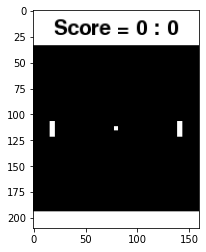

In [3]:
# Run this cell without modification

observations = envs.reset()

print("The observations shape is: {}.\nMeaning: batch size {}, "
      "number of channels {}, width {}, height {}".format(
      observations.shape, *observations.shape
))

plt.imshow(envs.envs[0].render("rgb_array"))

This is the processed observation that are then fed to the neural network.
We will discuss this later.


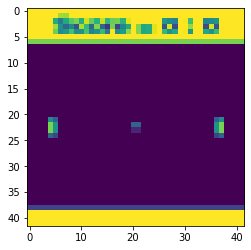

In [4]:
# Run this cell without modification

print("This is the processed observation that are then fed to the neural network.")
print("We will discuss this later.")
plt.imshow(observations[0, 0])

In [5]:
# Run this cell without modification

print("The single environment has action space: {}.\nYou are controlling the left pad."
      "action=0 means moving the pad down, action=1 means doing nothing, action=2 "
      "means moving the pad up.".format(envs.action_space))

The single environment has action space: Discrete(3).
You are controlling the left pad.action=0 means moving the pad down, action=1 means doing nothing, action=2 means moving the pad up.


In [6]:
# Run this cell without modification

print("Note that the vectorized environment take a list of interger as input.")
obs, reward, done, info = envs.step([0, 1, 0, 1, 0])
print("\n Observation Shape: ", obs.shape)
print("\n Reward: ", reward)
print("\n Done: ", done)
print("\n Info: ", info)

Note that the vectorized environment take a list of interger as input.

 Observation Shape:  (5, 1, 42, 42)

 Reward:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

 Done:  [[False]
 [False]
 [False]
 [False]
 [False]]

 Info:  [{'real_reward': 0.0, 'num_steps': 1}, {'real_reward': 0.0, 'num_steps': 1}, {'real_reward': 0.0, 'num_steps': 1}, {'real_reward': 0.0, 'num_steps': 1}, {'real_reward': 0.0, 'num_steps': 1}]


Note that the original cPong-v0 may have a different observation structure. We wrap a series of wrappers on the raw environment to make the training easier. We conclude those measures here:


1. We repeat an action for four times. During these four steps, we merge the raw four frames (210, 160, 3)\*4 into one frame (210, 160, 3)
2. Then, we merge three channels to one and resize the frame (210, 160, 3) to a small frame (42, 42, 1)
3. Then, we change the order of dimension (42, 42, 1) to fit the frame into pytorch (1, 42, 42)

Besides, we do another stacking when running the environment. We stack the latest 4 processed frames and make it looks like a frame with 4 channel, i.e. from (1, 42, 42)\*4 to (4, 42, 42). By doing this, in reality, the neural network can access the latest 16 raw frames information.

The following cells generate animation for you to have the first-person view as your agent does.

In [7]:
# Run this cell without modification

envs = make_envs("cPong-v0", num_envs=1, resized_dim=42)
frames = []
observations = []
obs = envs.reset()
print("The observation shape returned by the vectorized environment is: "
      "{}".format(obs.shape))
while True:
    action = [envs.action_space.sample()]
    obs, _, done, _ = envs.step(action)
    frame = envs.envs[0].render("rgb_array")
    observations.append(obs)
    frames.append(frame)
    if done:
        break
envs.close()

The observation shape returned by the vectorized environment is: (1, 1, 42, 42)


Raw observation from the environment (observation is identical to the return of env.render, so we show you the latter.)


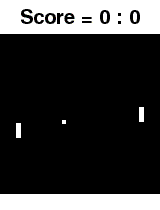

In [8]:
# Run this cell without modification

print("Raw observation from the environment "
      "(observation is identical to the return of env.render, so we show you "
      "the latter.)")
animate(frames)

Processed observation that are fed to the neural network. (We only resize it to see more clear in this cell.)


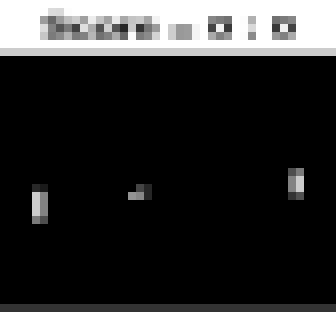

In [9]:
# Run this cell without modification

print("Processed observation that are fed to the neural network."
      " (We only resize it to see more clear in this cell.)")
obs = [
    cv2.resize(o.reshape((42, 42)), (42 * 8, 42 * 8), interpolation=cv2.INTER_NEAREST)
    for o in observations
]
animate(obs)

# Is this resolution enough? The answer is yes.

## Section 1.2: Two agents to play against each other

In the platform, we provide another environment called `cPongDouble-v0`, whose observation space and action space are both a tuple of size 2. This environment allows us to run two agents and beat against each other easily.

An important contribution of this environment is that this environment converts observations of both agents into the same form --- the agent controls the left pad. The environment mirrors the observation of the right-side agent in order to run an agent that train to play in the left-side.

In the next few cells, we take a look at what the observations look like. Then we introduce more high-level tools to evaluate your agents, with different level experts.

In [10]:
# Run this cell without modification

env = gym.make("cPongDouble-v0")  # , num_envs=1, resized_dim=42)
frames = []
observations = []
obs = env.reset()
print("The observation shape returned by the vectorized environment is: "
      "{}".format(obs[0].shape))
while True:
    action = [0, 1]  # We let the first agent moving up, and second agent does nothing.
    obs, _, done, _ = env.step(action)
    frame = env.render("rgb_array")
    observations.append(obs)
    frames.append(frame)
    if done:
        break
env.close()

The observation shape returned by the vectorized environment is: (210, 160, 3)


This is what happening in environment.


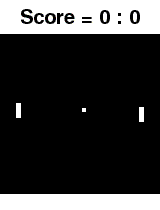

In [11]:
# Run this cell without modification

print("This is what happening in environment.")
animate(frames)

This is what the first agent (left agent) raw observation is.


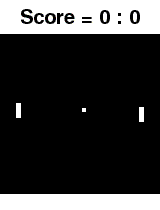

In [12]:
print("This is what the first agent (left agent) raw observation is.")
obs1 = [o for o, _ in observations]
animate(obs1)

This is what the second agent (right agent) raw observation is.


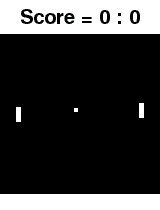

In [13]:
print("This is what the second agent (right agent) raw observation is.")
obs2 = [o for _, o in observations]
animate(obs2)

## Section 2: A2C and PPO Trainer

### Section 2.1: Finish the base trainer

You should finish `evaluate_actions` and `compute_action` in `core/base_trainer.py`.

### Section 2.2: Finish A2C trainer

You need to implement `update` and `compute_loss` function in `core/a2c_trainer.py`.

To compute the expected return which is then used to calculate the advantages, you need to implement `A2CRolloutStorage` in `core/buffer.py`

### Section 2.3: Finish PPO trainer

You need to implment `update` and `compute_loss` function in `core/ppo_trainer.py`.

To compute the expected return which is then used to compute the advantages, you need to implement `PPORolloutStorage` in `core/buffer.py`

Here we use GAE [1] (Generalized Advantage Estimation) to estimate the advantage. This technique is implemented in `PPORolloutStorage.compute_returns`

Concretely, we estimate the advantage of current state $t$ via:

$$\delta_t = r_t + \gamma V(s_t+1) - V(s_t)$$

$$A^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda) ^ l \delta_{t+l}$$

wherein $V$ is the state value function, $\lambda$ is a hyper-parameter defined in `core.ppo_trainer.ppo_config["gae_lambda"]`.

You can find that when $\lambda = 0$, the GAE estimates advantage in a one-step TD manner. When $\lambda = 1$, the GAE reduces to Monte Carlo Estimation of the state value. Therefore by varying the $\lambda$, we can make the trade-off between the accuracy of the estimation (bias) and the variance of advantage.

[1]: Schulman, John , et al. "High-Dimensional Continuous Control Using Generalized Advantage Estimation." (2015).

### Section 2.4: Test algorithms and train your agent

After implementing your algorithms, you can test both A2C and PPO algorithm using the same scripts:

```bash
# Blackbox test to make sure your A2C and PPO can run both in CartPole and Pong, with single or multiple environments.
python blackbox_tests.py

python train.py --algo PPO --env-id CartPole-v0  # Test your codes

python train.py --algo PPO --log-dir data/YOUR-LOG-DIR  # A formal training of PPO

python train.py --algo A2C --env-id CartPole-v0  # Test your codes

python train.py --algo A2C --log-dir data/YOUR-LOG-DIR  # A formal training of A2C
```

Notes: In our testing, PPO can solve CartPole-v0 in 200 iterations, A2C in 500 iterations.

### Section 2.5: Policy Serving API

You need to finish the file `this_is_my_agent.py`. Run the next cell to verify your implementation.

In [14]:
from this_is_my_agent import test, student_compute_action_function

test()

Can't find anything at checkpoint-.pkl!
Can't find anything at checkpoint-.pkl!
Test passed!


## Section 3: Play with builtin agents

We provide a group of trained agents to serve as opponents. We prepared 6 level builtin agents, including:

1. `RANDOM` - A random agent
2. `RULE_BASED` - Rule-based agent that serves as the right-side agent in `cPong-v0`
3. `WEAK` - Weak-level agent with a smaller neural network than yours
4. `MEDIUM` - Medium-level agent with a small neural network
5. `STRONG` - Strong-level agent with a large neural network as yours
6. `ALPHA_PONG` - Boss-level agent that is well trained and may hard to beat down, use a large neural network as yours

### Section 3.1: Visualize games between builtin agents and yours

You can run `this_is_my_agent.py` to visualize the game between those builtin agents and your agent. See the following cells.

Note: You can run the next cell even if you don't implement API, in which case the left agent would be random. You can change the flags in next cells to watch the game between different builtin agents.

In [15]:
run this_is_my_agent.py --left MY_AGENT --right ALPHA_PONG --num-episodes 1

Agent names:  ['RANDOM', 'WEAK', 'MEDIUM', 'STRONG', 'RULE_BASED', 'ALPHA_PONG', 'MY_AGENT']
Your chosen agents: left - MY_AGENT, right - ALPHA_PONG
Can't find anything at checkpoint-.pkl!
([0, 0, 1, -21.0], [1, 0, 0, 21.0])


In [16]:
run this_is_my_agent.py --left STRONG --right MEDIUM --num-episodes 1

Agent names:  ['RANDOM', 'WEAK', 'MEDIUM', 'STRONG', 'RULE_BASED', 'ALPHA_PONG', 'MY_AGENT']
Your chosen agents: left - STRONG, right - MEDIUM
([1, 0, 0, 1.0], [0, 0, 1, -1.0])


### Section 3.2: Train your agent using builtin agents (Optional)

In the previous section, we train agents using A2C or PPO algorithm on the `cPong-v0` environment, which means the opponent is a rule-based agent. 

We can train an agent competing with a set of diverse agents.

To do this, simply set the environment name to `cPongTournament-v0` and then run the same script above. For example, you can train the agent via:

```bash
python train.py --log-dir data/LOG-DIR-NAME --env-id cPongTournament-v0
```

Notes:

1. We do not implement the restore mechanism. So if you wish to finetune a trained agent with this competitive environment, please implement this by yourself.
2. We implement a function call `reset_opponent` for this tournament environemnt to allow user to reset the opponent if necessary. Please refer to `competitive_pong/competitive_pong_env.py` for more detail.
3. Currently, we randomly choose an opponent in all builtin agents and fix it for one training iteration, via calling `reset_opponent` in `train.py` (see codebolck below). In future, we can investigate the opponent selection strategy.

```python
# ===== Reset opponent if in tournament mode =====
if tournament and iteration % config.num_steps == 0:
    # Randomly choose one agent in each iteration
    envs.reset_opponent()
```

## Section 4: Evaluate your agent


The next cells run `evaluate.py`, the entrance to evaluate your agent. You need to finish the file `this_is_my_agent.py` first before running this file. This file would load your agent via the API in `this_is_my_agent.py` and evaluates your agent via launching games against other builtin agents.

But now, just the run the next cell and see what happens!

In [17]:
run evaluate.py --num-episodes 2 --num-envs 2

Can't find anything at checkpoint-.pkl!
All agents ready:  dict_keys(['RANDOM', 'WEAK', 'MEDIUM', 'STRONG', 'RULE_BASED', 'ALPHA_PONG', 'MY_AGENT'])


d:\workplace\ierg6130-assignment\assignment4\competitive-pong\competitive_pong\make_envs.py:60: UserWarning: Environment id CompetitivePongDouble-v0 is deprecated. Please use the short version cPongDouble-v0.
  warnings.warn(msg.format(env_id, replace_names[env_id]))


Environment ready
Can't find anything at checkpoint-.pkl!

Start evaluating agent  MY_AGENT

===== MY_AGENT VS RANDOM result =====
----- MY_AGENT -----
[MY_AGENT] Win:	0
[MY_AGENT] Draw:	0
[MY_AGENT] Lose:	2
[MY_AGENT] Win Rate:	0.00
[MY_AGENT] Cumulative Reward:	-10.000
[MY_AGENT] Episode Reward:	-5.000
[MY_AGENT] Total Matches:	2
[MY_AGENT] Test time:	1.53
----- RANDOM -----
[RANDOM] Win:	2
[RANDOM] Draw:	0
[RANDOM] Lose:	0
[RANDOM] Win Rate:	1.00
[RANDOM] Cumulative Reward:	10.000
[RANDOM] Episode Reward:	5.000
[RANDOM] Total Matches:	2
[RANDOM] Test time:	1.53

===== MY_AGENT VS WEAK result =====
----- MY_AGENT -----
[MY_AGENT] Win:	0
[MY_AGENT] Draw:	0
[MY_AGENT] Lose:	2
[MY_AGENT] Win Rate:	0.00
[MY_AGENT] Cumulative Reward:	-34.000
[MY_AGENT] Episode Reward:	-17.000
[MY_AGENT] Total Matches:	2
[MY_AGENT] Test time:	2.62
----- WEAK -----
[WEAK] Win:	2
[WEAK] Draw:	0
[WEAK] Lose:	0
[WEAK] Win Rate:	1.00
[WEAK] Cumulative Reward:	34.000
[WEAK] Episode Reward:	17.000
[WEAK] Total Ma

If you can run this file without bugs, then you are well prepared to get a formal record of your agent. Now run

`python evaluate.py`

to test your agent against builtin agents for 100 episodes each and include the generated `data/evaluate_result.csv` into your submission.


### Section 4.1 (Optional): What we will do after receiving your submission

After the deadline, we will collect all submissions and hold a tournament on all students' agents.

First, we merge all students' submitted checkpoints into "data" directory. (So you need to make sure your submitted checkpoint, i.e. pkl file, have a unique name.)

Then, we rename the function `student_compute_action_function` in `this_is_my_agent.py` to `student_YOUR-STUDENT-ID`. But we do not change the content in your function. So you need to make sure we can get your agent bug-free by directly call the function in `this_is_my_agent.py` when the working directory is `assignment4/`.

Third, we run this file `this_is_what_we_will_do.py`, which automatically gathers all functions in "this_is_my_agent.py" and launch a series of matches.

Finally, we summarize the match results of all your agents against others (including builtin agents) to a winning-rate matrix.

In conclusion, what you need to do for joining this tournament are:

1. Finish `this_is_my_agent.py` (do not need to change the function name)
2. Provide checkpoint file to us (it should have a unique name)
3. Check everything work wells (i.e., run the next cell)

In [18]:
run this_is_what_we_will_do.py --num-episodes 1 --num-envs 1

Can't find anything at checkpoint-.pkl!
Collected policies:  dict_keys(['compute_action_function'])


d:\workplace\ierg6130-assignment\assignment4\competitive-pong\competitive_pong\make_envs.py:60: UserWarning: Environment id CompetitivePongDouble-v0 is deprecated. Please use the short version cPongDouble-v0.
  warnings.warn(msg.format(env_id, replace_names[env_id]))


Environment ready
Start match between agent compute_action_function with dict_keys(['compute_action_function', 'RANDOM', 'WEAK', 'MEDIUM', 'STRONG', 'RULE_BASED', 'ALPHA_PONG']).

Start evaluating agent  compute_action_function

===== compute_action_function VS compute_action_function result =====
----- compute_action_function -----
[compute_action_function] Win:	1
[compute_action_function] Draw:	0
[compute_action_function] Lose:	0
[compute_action_function] Win Rate:	1.00
[compute_action_function] Cumulative Reward:	3.000
[compute_action_function] Episode Reward:	3.000
[compute_action_function] Total Matches:	1
[compute_action_function] Test time:	1.39
----- compute_action_function -----
[compute_action_function] Win:	0
[compute_action_function] Draw:	0
[compute_action_function] Lose:	1
[compute_action_function] Win Rate:	0.00
[compute_action_function] Cumulative Reward:	-3.000
[compute_action_function] Episode Reward:	-3.000
[compute_action_function] Total Matches:	1
[compute_action_f

------

## Conclusion and Discussion

In this assignment, we implement an RL pipeline that can be used in research.

Please follow the submission instruction in the assignment to submit your assignment to our staff. As a reminder, you don't need to submit this jupyter notebook to us.

This is the last assignment of this course. We appreciate you for joining this course and pay efforts to finish assignments. Hope this course can provide insights to you! Thanks!

------